In [1]:
import pandas as pd
import json
from collections import defaultdict
from intertrans.data import load_as_df, read_engine_output

# Set the display precision globally
pd.options.display.precision = 1


In [2]:
raw = read_engine_output('../data/raw_outputs/engine/codellama_13b_transcoder_results_all_depth4.json')

In [3]:
found_depth = {}

for rindex, response in enumerate(raw['translation_responses']):
    seed_language = response['translation_request']['seed_language']
    target_language = response['translation_request']['target_language']
    id_request = response['translation_request']['id']
    ignore_direct = False

    depth = 0
    for path in response['paths']:
        memoized_edges = path["edge_index_memoized"]
        if not ignore_direct:
            for index, edge in enumerate(path["translation_edges"]):
                if not memoized_edges[index]:
                    depth+=1
                    parent_id = edge["parent_edge_id"]
                    if edge["status"] == "TRANSLATION_FOUND" and parent_id == -1:
                        ignore_direct = True
                        break
                    elif edge["status"] == "TRANSLATION_FOUND":
                        found_depth[rindex] = depth
                        ignore_direct = True
                        break

In [38]:
response = raw['translation_responses'][78]

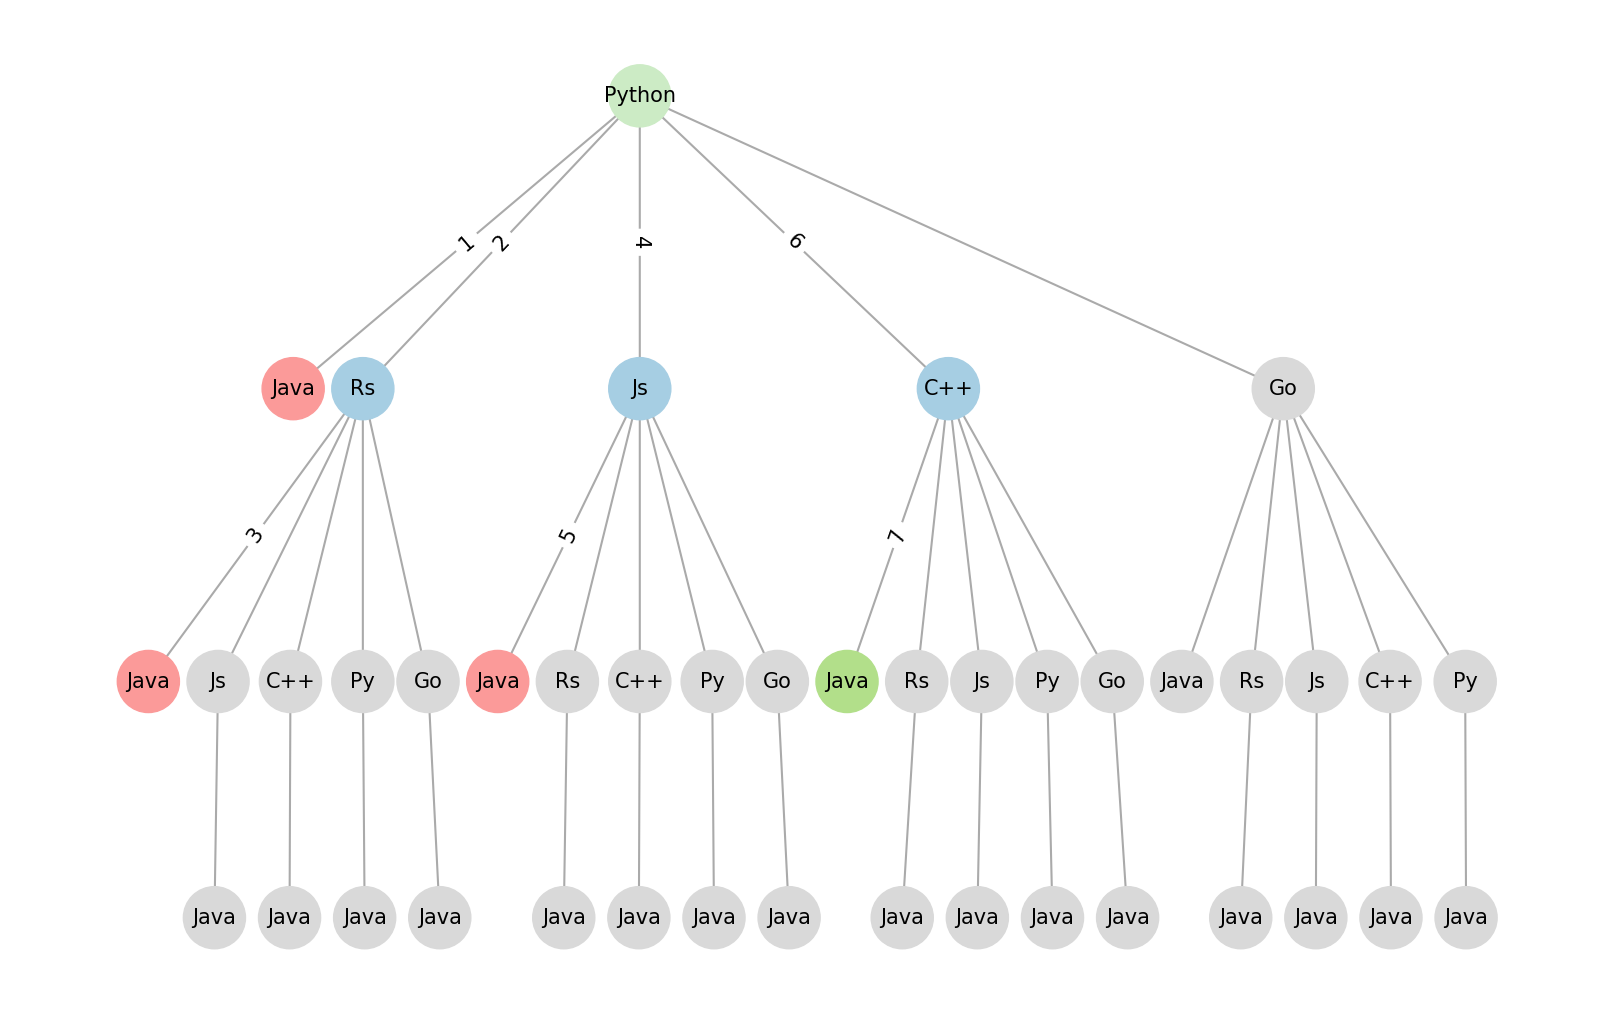

In [47]:
import matplotlib.pyplot as plt
import networkx as nx

# Iterate through each translation response in the raw JSON data
map_langs = {
    "C++": "C++",
    "Java": "Java",
    "Python": "Py",
    "Rust": "Rs",
    "Go": "Go",
    "JavaScript": "Js"
}

seed_language = response['translation_request']['seed_language']
target_language = response['translation_request']['target_language']
id_request = response['translation_request']['id']

G = nx.DiGraph()
counter = 1

G.add_node(-1, status="ROOT", label=seed_language)
skip_status = False

for path in response['paths']:
    memoized_edges = path["edge_index_memoized"]
    level = 1
    for index, edge in enumerate(path["translation_edges"]):
        if level <= 3:
            if not memoized_edges[index]:
                # This is for visualization purposes because we have 4 levels and with depth 3 leafs are be only to the target
                if level == 3 and edge["target_language"] != target_language:
                    level += 1
                    continue

                if skip_status:
                    edge_status = "SKIPPED_TRANSLATION_FOUND"
                    edge_label = ""
                else:
                    edge_status = edge["status"]
                    edge_label = f"{counter}"

                if edge_status == "TRANSLATION_FOUND":
                    skip_status = True

                edge_target = edge["target_language"]
                edge_input = edge["input_language"]
                parent_id = edge["parent_edge_id"]
                node_id = edge["edge_id"]
                G.add_node(node_id, status=f"{edge_status}", label=f"{map_langs[edge_target]}")

                # Add edge if there is a valid parent
                G.add_edge(parent_id, node_id, label=edge_label)
                counter += 1

            level += 1

# Define color map based on status
color_map = {
    "TRANSLATION_FOUND": "#B2DF8A",      # Light Green
    "SKIPPED_TRANSLATION_FOUND": "#D9D9D9", # Light Grey
    "SUCCESS": "#A6CEE3",                # Light Blue
    "TRANSLATED": "#A6CEE3",             # Light Blue
    "FAILED": "#FB9A99",                 # Light Red
    "SKIPPED_PARENT_FAILED": "#D9D9D9",  # Light Grey
    "SKIPPED_NO_EXTRACT": "#D9D9D9",     # Light Grey
    "FAILED_NO_EXTRACTED": "#FB9A99",    # Light Red
    "FAILED_EXECUTION": "#FB9A99",       # Light Red
    "FAILED_INFERENCE": "#FB9A99",       # Light Red
    "FAILED_VERIFICATION": "#FB9A99",    # Light Red
    "ROOT": "#CCEBC5"                    # Light Sky Blue
}

node_colors = [color_map[G.nodes[node]['status']] for node in G.nodes]

# Draw the graph
if nx.is_empty(G):
    print("The graph is empty.")
else:
    plt.figure(figsize=(16, 10))
    # Draw the graph using graphviz layout for tree structure
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

    # Draw nodes and edges with customized styles
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=1)
    nx.draw_networkx_edges(G, pos, edge_color='#aaaaaa', arrows=True, width=1.5)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=15, font_color='black')

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)  # Increased font size

    # # Add a legend
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for status, color in color_map.items()]
    # labels = [status for status in color_map.keys()]
    # plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title='Status')

    # Set plot style and show
    plt.rcParams['axes.facecolor'] = 'white'  # Set background color
    plt.axis('off')  # Turn off axis
    plt.tight_layout(pad=0.2)  # Decrease white space margin
    plt.show()